In [10]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from skimage import color, data
from skimage.io import imread_collection, imsave, imshow_collection
from skimage.transform import downscale_local_mean, rescale, resize

%matplotlib inline

In [11]:
def get_portable_path() -> Path:
    """Utility for getting a sensible working directory whether running as a script or in Colab"""
    try:
        outdir = Path(__file__).resolve().parent
        return outdir
    except NameError:
        print("Possible use of Colab detected. Attempting to exploit `globals()`...")
    try:
        outdir = Path(globals()["_dh"][0]).resolve()
        return outdir
    except KeyError:
        print("Colab not detected.")
        print("Defaulting to current working directory for files.")
        return Path().resolve()


In [12]:
OUTDIR = get_portable_path() / "outputs"
DATADIR = get_portable_path() / "dataset"


Possible use of Colab detected. Attempting to exploit `globals()`...
Possible use of Colab detected. Attempting to exploit `globals()`...


In [13]:
def show_images(population: list = []) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=2)

    ax = axes.ravel()

    ax[0].imshow(population[0])
    ax[0].set_title("1")

    ax[1].imshow(population[1])
    ax[1].set_title("2")

    ax[2].imshow(population[2])
    ax[2].set_title("2")

    ax[3].imshow(population[3])
    ax[3].set_title("3")

    plt.tight_layout()
    display.clear_output(wait=True)
    plt.show()
    plt.pause(1)


In [14]:
class EvolutionaryArtGA:
    def __init__(
        self,
        max_gen=10,
        pop_size=4,
        image_size=(256, 256),
        show_images=show_images,
        num_display=4,
        show_freq=10,
        mut_func_ver=1,
        cross_func_ver=1,
        **kwargs
    ) -> None:
        """Init params for the evolutionary art GA

        Args:
            max_gen (int, optional): maximum generation. Defaults to 10.
            pop_size (int, optional): maximum population size. Defaults to 4.
            image_size (tuple, optional): size of each image. Defaults to (256, 256).
            show_images (func, optional): function to display images. Defaults to show_images.
            num_display (int, optional): maximum number of images to display. Defaults to 4.
            show_freq (int, optional): frequency of the images to display. Defaults to every 10% of max_gen
            mut_func_ver (int, optional): the mutation function version to be used
            cross_func_ver (int, optional): the crossover function version to be used
        """
        self.max_gen = max_gen
        self.pop_size = pop_size
        self.image_size = image_size
        self.population = []
        self.show_images = show_images
        self.num_display = num_display
        self.show_freq = show_freq
        self.mut_func_ver = mut_func_ver
        self.cross_func_ver = cross_func_ver
        self.kwargs = kwargs

    def get_func(self, func_name: str):
        "Helper to get the correct function"
        if hasattr(self, func_name) and callable(func := getattr(self, func_name)):
            return func
        else:
            print(f"Make sure {func_name} exists in the class")
            raise NotImplementedError(f"Function {func_name} is not implemented")

    def init_population(self):
        # creating a collection with the available images
        images = imread_collection(str(DATADIR / "train" / "*.jpg"))
        for img in images[: self.pop_size]:
            self.population.append(resize(img, self.image_size, anti_aliasing=True))
        print(f"Displaying first {self.num_display} images from initial population")
        self.show_images(self.population[:4])

    def mutation_1(self, gene) -> np.ndarray:
        """[Mutation 1]
        Gene is a (IMAGE_SIZE) * 3 channel input image.
        Here mutate is swapping the values within the image between channels
        """
        x = random.randint(0, self.image_size[0] - 1)
        y = random.randint(x, self.image_size[1] - 1)
        ch1 = random.randint(0, 2)
        ch2 = random.randint(0, 2)
        # get the rectangle
        gene[x:y, x:y, ch1], gene[x:y, x:y, ch2] = (
            gene[x:y, x:y, ch2],
            gene[x:y, x:y, ch1],
        )
        return gene

    def crossover_1(self, gene1, gene2):
        """[Crossover 1]
        Gene is a (IMAGE_SIZE) * 3 channel input image.
        Here crossover is swapping the values of one channel between images
        """
        x = random.randint(0, self.image_size[0] - 1)
        y = random.randint(x, self.image_size[1] - 1)
        ch1 = random.randint(0, 2)
        ch2 = random.randint(0, 2)
        # get the square
        gene1[x:y, x:y, ch1], gene1[x:y, x:y, ch2] = (
            gene2[x:y, x:y, ch2],
            gene2[x:y, x:y, ch1],
        )
        return gene1

    def run(self) -> list:
        """Runs the algorithm and returns the population

        Returns:
            list: [Population]
        """
        self.init_population()
        for gen_idx in range(self.max_gen):
            for gene in self.population:
                # Mutation
                gene = self.get_func(f"mutation_{self.mut_func_ver}")(gene)
                # crossover
                gene = self.get_func(f"crossover_{self.cross_func_ver}")(
                    gene, self.population[random.randint(0, self.pop_size - 1)]
                )
            if (gen_idx % (self.max_gen * 0.1)) == 0:
                self.show_images(self.population[: self.num_display])
        print(f"Max generation size: {self.max_gen} reached")
        return self.population


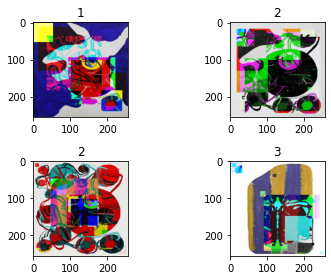

In [15]:
art_ga = EvolutionaryArtGA(
    max_gen=10, pop_size=4, image_size=(256, 256), mut_func_ver=1, cross_func_ver=1
)
population = art_ga.run()
